In [11]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = '../open/'
info = pd.read_excel(data_path+'clinical_info.xlsx')

df_train = pd.read_csv(data_path+'train.csv')
df_test = pd.read_csv(data_path+'test.csv')
sub = pd.read_csv(data_path+'sample_submission.csv')

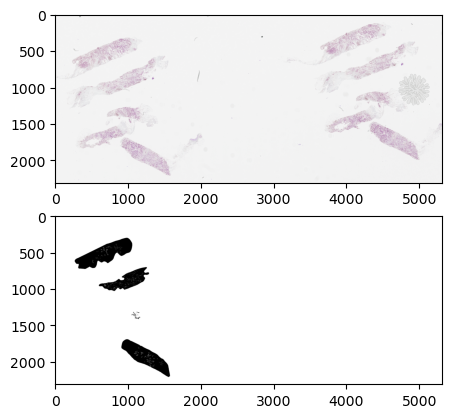

In [17]:
img = cv2.imread('../open/train_imgs/BC_01_0015.png')
mask = cv2.imread('../open/train_masks/BC_01_0015.png')
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.imshow(img)
plt.subplot(2,1,2)
plt.imshow(mask)
plt.show()

In [13]:
df_train[lambda x: x['mask_path']!='-']

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
13,BC_01_0015,./train_imgs/BC_01_0015.png,./train_masks/BC_01_0015.png,43,2019-02-11,4,1,2,13.0,2.0,...,7.0,1.0,8.0,10.01,0.0,2.0,0.0,1.23,NaN,0
80,BC_01_0397,./train_imgs/BC_01_0397.png,./train_masks/BC_01_0397.png,60,2020-01-08,1,2,1,23.0,2.0,...,7.0,1.0,6.0,20.22,0.0,0.0,NaN,NaN,NaN,1
81,BC_01_0398,./train_imgs/BC_01_0398.png,./train_masks/BC_01_0398.png,58,2019-12-12,1,2,1,13.0,2.0,...,8.0,1.0,5.0,20.93,0.0,1.0,NaN,NaN,NaN,1
82,BC_01_0404,./train_imgs/BC_01_0404.png,./train_masks/BC_01_0404.png,72,2019-12-26,1,2,1,13.0,2.0,...,7.0,1.0,8.0,6.38,0.0,1.0,NaN,NaN,NaN,1
84,BC_01_0417,./train_imgs/BC_01_0417.png,./train_masks/BC_01_0417.png,51,2019-12-05,1,2,2,21.0,2.0,...,7.0,0.0,NaN,18.86,0.0,2.0,0.0,1.27,NaN,1
86,BC_01_0425,./train_imgs/BC_01_0425.png,./train_masks/BC_01_0425.png,46,2019-12-12,4,1,1,5.0,1.0,...,6.0,1.0,6.0,4.60,0.0,2.0,0.0,1.10,NaN,0
88,BC_01_0451,./train_imgs/BC_01_0451.png,./train_masks/BC_01_0451.png,33,2019-11-05,1,2,2,22.0,3.0,...,6.0,1.0,4.0,44.92,0.0,2.0,0.0,1.42,NaN,1
89,BC_01_0454,./train_imgs/BC_01_0454.png,./train_masks/BC_01_0454.png,62,2019-10-22,1,1,1,13.0,2.0,...,7.0,1.0,6.0,11.84,0.0,2.0,0.0,1.32,NaN,1
90,BC_01_0455,./train_imgs/BC_01_0455.png,./train_masks/BC_01_0455.png,46,2019-10-07,1,2,1,14.0,2.0,...,7.0,1.0,8.0,16.37,0.0,1.0,NaN,NaN,NaN,1
91,BC_01_0457,./train_imgs/BC_01_0457.png,./train_masks/BC_01_0457.png,44,2019-10-30,2,2,2,40.0,2.0,...,7.0,1.0,6.0,2.60,0.0,1.0,NaN,NaN,NaN,1


In [7]:
df_test

,ID,img_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0011,./test_imgs/BC_01_0011.png,55,2015-11-17,2,2,1,23.0,2.0,2.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,BC_01_0220,./test_imgs/BC_01_0220.png,43,2020-06-09,4,2,1,13.0,3.0,2.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,BC_01_0233,./test_imgs/BC_01_0233.png,76,2020-05-14,1,1,1,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN
3,BC_01_0258,./test_imgs/BC_01_0258.png,58,2020-05-20,1,2,1,1.3,2.0,2.0,...,1.0,7.0,0.0,NaN,21.17,1.0,3.0,NaN,NaN,0.0
4,BC_01_0260,./test_imgs/BC_01_0260.png,56,2020-05-20,1,2,2,15.0,3.0,3.0,...,1.0,8.0,1.0,3.0,20.57,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,BC_01_3328,./test_imgs/BC_01_3328.png,61,2009-10-30,1,1,1,18.0,2.0,2.0,...,1.0,5.0,1.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN
246,BC_01_3404,./test_imgs/BC_01_3404.png,42,2009-05-19,1,2,1,20.0,1.0,2.0,...,1.0,5.0,1.0,5.0,NaN,0.0,1.0,NaN,NaN,NaN
247,BC_01_3418,./test_imgs/BC_01_3418.png,37,2009-04-24,1,1,1,17.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN
248,BC_01_3438,./test_imgs/BC_01_3438.png,37,2009-02-06,1,1,1,7.0,1.0,1.0,...,1.0,5.0,1.0,5.0,NaN,0.0,0.0,NaN,NaN,NaN
